<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/DiskActuator/OptimalCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as mpl
from scipy.optimize import fsolve, fmin, minimize_scalar, curve_fit

In [2]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', \
                                                   '#d62728', '#9467bd', '#8c564b', \
                                                   '#e377c2', '#7f7f7f', '#bcbd22', \
                                                   '#17becf'] )
mpl.rcParams['lines.linewidth'] = 1.5
%config InlineBackend.figure_formats = ['svg']

# **Warning**

Before running this notebook, the locus of optimal values of $C_P$ as function of $C_T$ and $\mathrm{Fr}_1$ are described in the notebook: 

https://github.com/joaochenriques/MCTE_2022/blob/main/DiskActuator/Sensitivity_Analysis.ipynb

In [3]:
def CardanoRoots( aa, bb ):
  # Cardano algorithm to solve our polynomial, see:
  # https://www.shsu.edu/kws006/professional/Concepts_files/SolvingCubics.pdf
  P = -2.0*aa
  Q = -2.0*bb
  Δ = (P/3.0)**3 + (Q/2)**2
  if Δ < 0.0: Δ = Δ + 0J
  β = ( -Q/2.0 - np.sqrt(Δ) )**(1.0/3.0)
  α = P/(3.0*β)
  ω = ( -1.0 + np.sqrt(3.0)*1J) / 2.0
  
  x1 = α - β
  x2 = (α*ω - β)*ω
  x3 = (α - β*ω)*ω

  if np.imag(x1) < 1E-15: x1 = np.real( x1 )
  if np.imag(x2) < 1E-15: x2 = np.real( x2 )
  if np.imag(x3) < 1E-15: x3 = np.real( x3 )

  # applies only for this solution 
  assert( np.imag( x1 ) == 0 )
  assert( np.imag( x2 ) == 0 )
  assert( np.imag( x3 ) == 0 )
  assert( x1 <= 0.0 )
  assert( x2 <= x3 )

  return (x2, x3)

In [4]:
def compute_CT_CP_Frs( Fr4b, Fr1, B ): 

    # These Eqs. are described in
    # https://github.com/joaochenriques/MCTE_2020_2021/blob/main/DiskActuator/DiskActuator.ipynb

    ζ4 = (1.0/2.0)*Fr1**2 - 1.0/2.0*Fr4b**2 + 1.0

    C1 = Fr1 - Fr4b*ζ4
    C2 = B**2*Fr4b**2 - 2*B*Fr1**2 + 2*B*Fr1*Fr4b \
            + B*ζ4**2 - B + Fr1**2 - 2*Fr1*Fr4b*ζ4 + Fr4b**2*ζ4**2

    Fr4t = ( C1 + np.sqrt(C2) ) / B
    ζ4t = ( Fr4b*ζ4 - Fr1 ) / ( Fr4b - Fr4t )
    ζ4b = ζ4 - ζ4t

    Fr2t = Fr4t*ζ4t/B
    C_T = (Fr4b**2 - Fr4t**2)/Fr1**2
    C_P = C_T*Fr2t/Fr1

    mb = Fr4b*ζ4b + Fr4t*ζ4t
    bb = mb**2
    aa = (Fr4b**2*ζ4b + Fr4t**2*ζ4t + 1/2*ζ4**2)

    ζs = CardanoRoots( aa, bb )
    ζ5 = ζs[1]
    Fr5 = mb / ζ5

    return C_T, C_P, Fr2t, Fr4t, Fr5

In [5]:
def find_minus_C_P( Fr4b, Fr1, B ): 
    # function created to discard the C_T when calling "compute_C_T_and_C_P"
    _, C_P, _, _, _ = compute_CT_CP_Frs( Fr4b, Fr1, B ) 
    return -C_P # Minus C_P to allow minimization

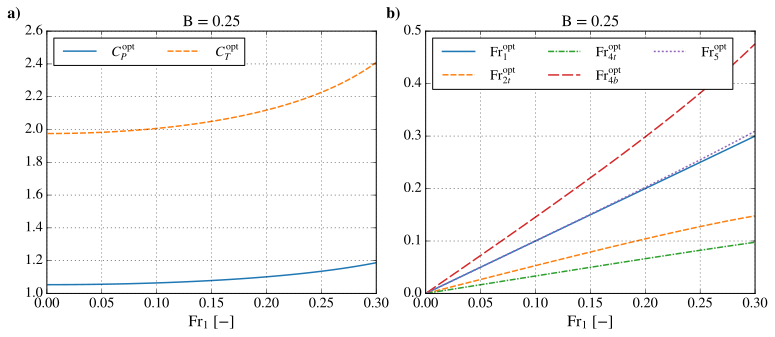

In [15]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.15 )

# Blockage factor 
B = 0.25

# define Fr1 interval and number of points
Fr1_min = 1E-3
Fr1_max = 0.3
Fr1_num = 50

Fr1_opt_vec = np.linspace( Fr1_min, Fr1_max, Fr1_num )

C_P_opt_vec  = np.zeros( Fr1_num )
C_T_opt_vec  = np.zeros( Fr1_num )
Fr2t_opt_vec  = np.zeros( Fr1_num )
Fr4b_opt_vec = np.zeros( Fr1_num )
Fr4t_opt_vec = np.zeros( Fr1_num )
Fr5_opt_vec  = np.zeros( Fr1_num )

for i, Fr1 in enumerate( Fr1_opt_vec ):

  res = minimize_scalar( find_minus_C_P, args=(Fr1, B), bounds=[0,1], method='bounded', 
                         options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
  Fr4b = res.x # optimal value

  C_T, C_P, Fr2t, Fr4t, Fr5 = compute_CT_CP_Frs( Fr4b, Fr1, B )

  C_T_opt_vec[i]  = C_T
  C_P_opt_vec[i]  = C_P
  Fr2t_opt_vec[i] = Fr2t
  Fr4b_opt_vec[i] = Fr4b
  Fr4t_opt_vec[i] = Fr4t
  Fr5_opt_vec[i]  = Fr5
  
ax1.plot( Fr1_opt_vec, C_P_opt_vec, label='$C_P^\mathrm{opt}$' )
ax1.plot( Fr1_opt_vec, C_T_opt_vec, dashes = (6,2), label='$C_T^\mathrm{opt}$' )
ax1.set_title( "B = %.2f" % B )
ax1.legend(loc='upper left', fontsize=14, handlelength=2.9, ncol=3)
ax1.set_xlabel("$\mathrm{Fr}_1\ [-]$")
ax1.grid()
ax1.text(-0.12, 1.05, 'a)', transform=ax1.transAxes, size=16, weight='semibold')

ax2.plot( Fr1_opt_vec, Fr1_opt_vec,  '-', label='$\mathrm{Fr}_{1}^\mathrm{opt}$' )
ax2.plot( Fr1_opt_vec, Fr2t_opt_vec, '-', dashes = (6,2), label='$\mathrm{Fr}_{2t}^\mathrm{opt}$' )
ax2.plot( Fr1_opt_vec, Fr4t_opt_vec, '-', dashes = (6,1.5,1.5,1.5), label='$\mathrm{Fr}_{4t}^\mathrm{opt}$' )
ax2.plot( Fr1_opt_vec, Fr4b_opt_vec, '-', dashes = (11,3), label='$\mathrm{Fr}_{4b}^\mathrm{opt}$' )
ax2.plot( Fr1_opt_vec, Fr5_opt_vec,  '-', dashes = (2,2), label='$\mathrm{Fr}_5^\mathrm{opt}$' )
ax2.set_title( "B = %.2f" % B )
ax2.legend(loc='upper left', fontsize=14, handlelength=2.9, ncol=3)
ax2.set_xlabel("$\mathrm{Fr}_1\ [-]$")
ax2.grid()
ax2.text(-0.12, 1.05, 'b)', transform=ax2.transAxes, size=16, weight='semibold');

## **Polynomial fitting**

Fit a polynomial of the type 

$$ a x^6 + b x^4 + c x^2 + d$$

to the optimal $C_T$ and $C_P$. This polynomial has only even monomial to avoid double curvature.


In [7]:
def fitting_func( x, a, b, c, d ):
    x2 = x*x
    return ( ( ( a * x2 + b ) * x2 + c ) * x2 ) + d

C_P_popt, C_P_pcov = curve_fit( fitting_func, Fr1_opt_vec, C_P_opt_vec )
C_T_popt, C_P_pcov = curve_fit( fitting_func, Fr1_opt_vec, C_T_opt_vec )

## **Optimal $C_T$ and $C_P$**

In [8]:
sFr_1, sC_P, sC_T = sp.symbols( "\mathrm{Fr}_1, C_\mathrm{P}, C_\mathrm{T}" )
eqCP = sp.Eq( sC_P, fitting_func( sFr_1, *C_P_popt ) )
sp.expand( eqCP )

Eq(C_\mathrm{P}, 28.8859259347912*\mathrm{Fr}_1**6 + 2.04365613159377*\mathrm{Fr}_1**4 + 1.07009424131169*\mathrm{Fr}_1**2 + 1.05344220378787)

In [9]:
eqCT = sp.Eq( sC_T, fitting_func( sFr_1, *C_T_popt ) )
sp.expand( eqCT )

Eq(C_\mathrm{T}, 159.432581448492*\mathrm{Fr}_1**6 + 4.11917075207753*\mathrm{Fr}_1**4 + 3.14853204708291*\mathrm{Fr}_1**2 + 1.97493773905267)

## **Plot results of the optimization and interpolation of the maxima**

In [10]:
fit_C_P = fitting_func( Fr1_opt_vec, *C_P_popt )
fit_C_T = fitting_func( Fr1_opt_vec, *C_T_popt )

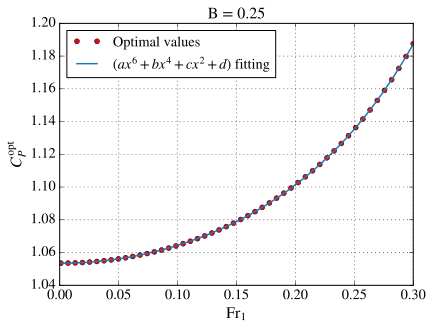

In [11]:
mpl.plot( Fr1_opt_vec, C_P_opt_vec, 'ro', label="Optimal values" )
mpl.plot( Fr1_opt_vec, fit_C_P, label="$(ax^6+bx^4+cx^2+d)$ fitting" )

mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$C_P^\mathrm{opt}$")
mpl.legend(loc='upper left')
mpl.grid()

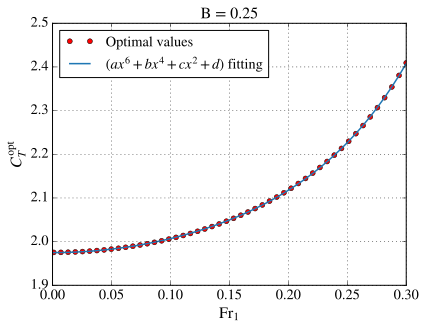

In [12]:
mpl.plot( Fr1_opt_vec, C_T_opt_vec, 'ro', label="Optimal values" )
mpl.plot( Fr1_opt_vec, fit_C_T, label="$(ax^6+bx^4+cx^2+d)$ fitting" )

mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$C_T^\mathrm{opt}$")
mpl.legend(loc='upper left')
mpl.grid()